# Improving The Model

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import BaggingRegressor

import xgboost as xgb

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare
import model

In [2]:
df_in = acquire.get_data(query_url = False)
print(df_in.shape)
df_in = prepare.prepare_dataframe(df_in)
df_in = model.prepare_model_df(df_in) # DO NOT USE THIS LINE IF NOT MODELING
train, validate, test = prepare.split_data(df_in)
print(str(train.shape) + str(validate.shape) + str(test.shape))

Found file in working directory!
(70932, 83)
(40311, 339)(6719, 339)(6719, 339)


# Introduction to Modeling
- Since most cards that are recently published are lower in value, card prices are capped at $200
    - Any card over $200 can be interpreted as simply an expensive card.
- Clusters are used as a feature in the models by a KMeans algorithm
    - Making two columns with 5 and 6 clusters each are used, created using the data without the target variable
    - Clusters stratified by USD price, usually with one cluster representing signifcantly more valuable cards
- Two evaluation metrics are used:
    - Mean Absolute Error (MAE).  This is chosen because models tended to poorly predict expensive cards, leading to the RMSE being a poor metric since it over emphasizes large errors
    - Card predictions within a dime of the actual value.  The models tended to be better at predicting lower priced cards.  Since the use case is to determine if new cards hit many price points in the market, if a larger percentage of cards are accurately predicted, more price points can be easily marketed to with the model.

# Baseline Model
- Two baseline models are created and evaluated
- One uses the median USD price and the other uses the mean USD price
- The baseline model using the median price more accurately predicts the price, and predicts a higher percentage of cards within a dime

In [3]:
model.make_baseline_model(train, validate, return_df = True).set_index('model')

,train_MAE,train_within_a_dime,validate_MAE,validate_within_a_dime
model,,,,
baseline_mean,5.827456,0.004267,5.724399,0.005953
baseline_median,3.721033,0.311974,3.632730,0.308677


# Choosing top model algorithms
- A series of different model algorithms are compared against the baseline models
- The top performing models are used to improve upon by determinng the number of features needed for the model
    - RandomForestRegressor : This has the lowest MAE and one of the higher rates of within-a-dime predictions
    - KNeighborsRegressor wighted by distance : This model has the second lower MAE and had a high rate of within-a-dime predictions
    - DecisionTreeRegressor: This model had the highest rate of within-a-dime predictions
    - LinearSVR : This model had a high rate of predictions within a dime

In [4]:
outputs = model.model_loop(train, validate)

In [5]:
pd.DataFrame(outputs).set_index('model').sort_values('validate_MAE')

,train_MAE,train_within_a_dime,validate_MAE,validate_within_a_dime
model,,,,
RandomForestRegressor,1.443272,0.511945,2.759130e+00,0.420003
KNeighborsRegressor_weighted,0.926974,0.730545,2.927149e+00,0.432803
KNeighborsRegressor,2.482755,0.456898,2.994726e+00,0.412561
DecisionTreeRegressor,0.913396,0.728883,3.085625e+00,0.454978
LinearSVR,3.386155,0.397112,3.297832e+00,0.389790
XGBoostRegressor,3.407522,0.062489,3.599480e+00,0.060426
baseline_median,3.721033,0.311974,3.632730e+00,0.308677
RadiusNeighborsRegressor_weighted,0.913396,0.728784,3.639562e+00,0.325197
RadiusNeighborsRegressor,5.428092,0.007045,5.330757e+00,0.007590


# Second Level Models
- Four models are chosen to determine the best feature selection
- The KBest algorithm is used to determine the optimal number of features for the model
- The best performing model was a RandomForestRegression with 300 of the features.  However, the difference all of the top three models (all RandomForestRegressor) were less than one thousandth of a dollar/percentage for both the MAE and predctions within a dime metrics.
    - Therefore a RandomForestRegressor with 200 features is used as the final model.

In [6]:
outputs = model.make_models_features(train, validate)

In [7]:
pd.DataFrame(outputs).set_index('model').sort_values('validate_MAE')

,train_MAE,train_within_a_dime,validate_MAE,validate_within_a_dime,kbest_features
model,,,,,
RandomForestRegression,1.482841,0.507380,2.768181,0.419408,300.0
RandomForestRegression,1.511818,0.502319,2.791166,0.414496,250.0
RandomForestRegression,1.559425,0.494629,2.794763,0.412561,200.0
KNeighborsRegressor_weighted,1.044276,0.713006,2.885796,0.441435,250.0
KNeighborsRegressor_weighted,1.105560,0.694699,2.905213,0.445751,200.0
KNeighborsRegressor_weighted,1.007862,0.726675,2.915711,0.446346,300.0
RandomForestRegression,1.876812,0.448438,2.916303,0.400804,100.0
DecisionTreeRegresson,0.965975,0.718935,2.988765,0.455723,300.0
RandomForestRegression,1.705599,0.484731,2.993572,0.410031,150.0


# Final Model
- The final model is a RandomForestRegressor with 200 features and predictions are made on unseen test data
- The model metrics improve with the test data in both MAE and within-a-dime
- From plotting the residuals, it is clear that more expensive cards are likely to be underestimated; sometimes by a significant amount.

In [8]:
metrics_output, test_predictions = model.final_model(train, validate, test)

In [9]:
pd.DataFrame(metrics_output).set_index('model')

,train_MAE,train_within_a_dime,validate_MAE,validate_within_a_dime,test_MAE,test_within_a_dime
model,,,,,,
RandomForestRegressor,1.511818,0.502319,2.791166,0.414496,2.530789,0.421938


<AxesSubplot:>

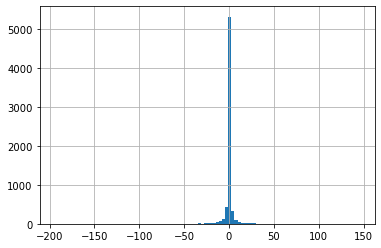

In [31]:
test_predictions['residual'].hist(bins = 100)

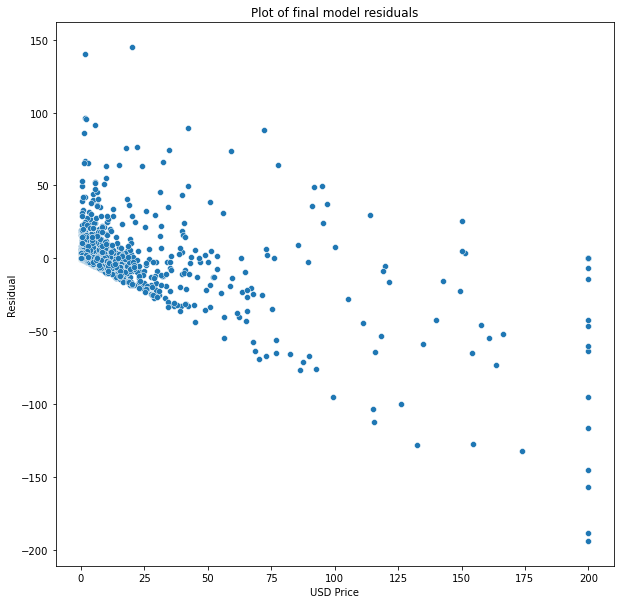

In [10]:
model.residual_plot(test_predictions)